# Data Loading And Preproces

In [121]:
!pip install datasets




In [122]:
import tensorflow as tf
from pathlib import Path
import numpy as np
import datasets
import matplotlib.pyplot as plt

In [123]:
from datasets import load_dataset
#datasets.config.DOWNLOAD_TIMEOUT = 120

dataset = load_dataset("opus100", "el-en")




In [124]:
print(dataset["train"][1])

{'translation': {'el': '- Αν εσύ...', 'en': '- If you...'}}


In [125]:
dataset


DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [126]:
len(dataset['train']['translation'])

1000000

In [127]:
greek=[item['el'] for item in dataset['train']['translation'][:100000]]# I took smaler data set because it didn't load into colab
eng=[item['en'] for item in dataset['train']['translation'][:100000]]

In [128]:
greek=np.array(greek)
eng=np.array(eng)

In [129]:
len(greek)

100000

In [130]:
print(greek[1],"=",eng[1])

- Αν εσύ... = - If you...


In [131]:
type(greek)


numpy.ndarray

In [132]:
text_vect_en=tf.keras.layers.TextVectorization(max_tokens=10000,
                                               output_sequence_length=20,standardize='lower_and_strip_punctuation')
text_vect_en.adapt(eng)


text_vect_gr=tf.keras.layers.TextVectorization(max_tokens=10000,
                                               output_sequence_length=20,standardize='lower_and_strip_punctuation')
text_vect_gr.adapt([f'SOS {s} EOS' for s in greek])



In [133]:
text_vect_gr(greek[1])# it seems that i should use masking

<tf.Tensor: shape=(20,), dtype=int64, numpy=
array([ 66, 104,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])>

In [134]:
text_vect_en.get_vocabulary()[:5]


['', '[UNK]', np.str_('the'), np.str_('you'), np.str_('to')]

In [135]:
text_vect_gr.get_vocabulary()[:5]

['', '[UNK]', np.str_('sos'), np.str_('eos'), np.str_('να')]

In [136]:
text_vect_gr.vocabulary_size()

10000

In [137]:
vocab_size_en=text_vect_en.vocabulary_size()
vocab_size_gr=text_vect_gr.vocabulary_size()

In [152]:
X_train_encoder=tf.constant(eng[:80000],dtype=tf.string)
X_valid_encoder=tf.constant(eng[80000:],dtype=tf.string)

X_train_decoder=tf.constant([f"SOS {s} " for s in greek[:80000]],dtype=tf.string)
X_valid_decoder=tf.constant([f"SOS {s} " for s in greek[80000:]],dtype=tf.string)

Y_train=[f" {s} EOS" for s in greek[:80000]]
Y_valid=[f" {s} EOS" for s in greek[80000:]]

In [139]:
type(X_train_decoder)

tensorflow.python.framework.ops.EagerTensor

In [140]:
text_vect_gr(X_train_decoder[1])

<tf.Tensor: shape=(20,), dtype=int64, numpy=
array([  2,  66, 104,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])>

In [141]:
text_vect_gr(Y_train[1])

<tf.Tensor: shape=(20,), dtype=int64, numpy=
array([ 66, 104,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])>

# Model_1

In [159]:
encoder_embedding=tf.keras.layers.Embedding(vocab_size_en,
                                            output_dim=10,
                                            mask_zero=True)
decoder_embedding=tf.keras.layers.Embedding(vocab_size_gr,
                                            output_dim=10,
                                            mask_zero=True)

In [100]:
encoder_inputs=tf.keras.layers.Input(shape=[],dtype=tf.string)
decoder_inputs=tf.keras.layers.Input(shape=[],dtype=tf.string)

encoder_vec=text_vect_en(encoder_inputs)
decoder_vec=text_vect_gr(decoder_inputs)

encoded_emb=encoder_embedding(encoder_vec)
decoded_emb=decoder_embedding(decoder_vec)

encoder=tf.keras.layers.LSTM(128,return_state=True,return_sequences=False)
encoder_outputs,*encoder_state=encoder(encoded_emb)



decoder=tf.keras.layers.LSTM(128,return_sequences=True)
decoder_outputs=decoder(decoded_emb,initial_state=encoder_state)

output_layer=tf.keras.layers.Dense(vocab_size_gr, activation='softmax')
Y_prob=output_layer(decoder_outputs)


In [101]:
Checkpoint=tf.keras.callbacks.ModelCheckpoint(
    'model_1.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min')


early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1,restore_best_weights=True,mode='min')

model=tf.keras.Model(inputs=[encoder_inputs,decoder_inputs],outputs=[Y_prob])
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Nadam(learning_rate=0.003),metrics=["accuracy"])

In [157]:
Y_train_vec=text_vect_gr(Y_train)
Y_valid_vec=text_vect_gr(Y_valid)

In [103]:
decoder_outputs.shape

(None, 20, 128)

In [104]:
encoder_outputs.shape

(None, 128)

In [105]:
history_1 = model.fit((X_train_encoder, X_train_decoder), Y_train_vec,
                      validation_data=((X_valid_encoder, X_valid_decoder), Y_valid_vec),
                      epochs=20, callbacks=[Checkpoint,early_stop])


Epoch 1/20
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6963 - loss: 2.3337
Epoch 1: val_loss improved from inf to 1.80038, saving model to model_1.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 70s 43ms/step - accuracy: 0.6964 - loss: 2.3333 - val_accuracy: 0.7297 - val_loss: 1.8004
Epoch 2/20
1561/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7319 - loss: 1.7448
Epoch 2: val_loss improved from 1.80038 to 1.66770, saving model to model_1.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 96s 52ms/step - accuracy: 0.7319 - loss: 1.7447 - val_accuracy: 0.7397 - val_loss: 1.6677
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7420 - loss: 1.5976
Epoch 3: val_loss improved from 1.66770 to 1.59261, saving model to model_1.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 141s 52ms/step - accuracy: 0.7420 - loss: 1.5976 - val_accuracy: 0.7468 - val_loss: 1.5926
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7488 - loss: 1.4860
Epoch 4: val_loss improved from 1.5926

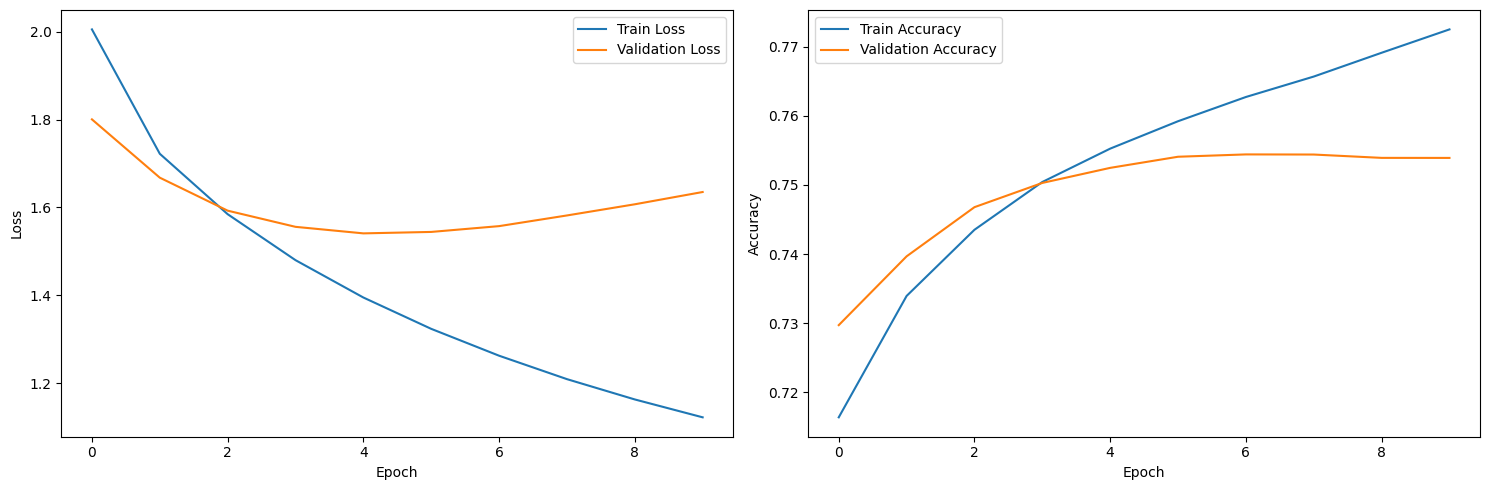

In [106]:
fig,axes=plt.subplots(1,2,figsize=(15,5))

axes[0].plot(history_1.history['loss'],label='Train Loss')
axes[0].plot(history_1.history['val_loss'],label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(history_1.history['accuracy'],label='Train Accuracy')
axes[1].plot(history_1.history['val_accuracy'],label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()

# Translate With Attention Layer

In [154]:
encoder_inputs=tf.keras.layers.Input(shape=[],dtype=tf.string)
decoder_inputs=tf.keras.layers.Input(shape=[],dtype=tf.string)

encoder_vec=text_vect_en(encoder_inputs)
decoder_vec=text_vect_gr(decoder_inputs)

encoded_emb=encoder_embedding(encoder_vec)
decoded_emb=decoder_embedding(decoder_vec)

encoder=tf.keras.layers.LSTM(128,return_state=True,return_sequences=True)
encoder_outputs,*encoder_state=encoder(encoded_emb)



decoder=tf.keras.layers.LSTM(128,return_sequences=True)
decoder_outputs=decoder(decoded_emb,initial_state=encoder_state)

attention_layer = tf.keras.layers.Attention()
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
output_layer = tf.keras.layers.Dense(vocab_size_gr, activation="softmax")
Y_proba = output_layer(attention_outputs)

In [155]:
Checkpoint=tf.keras.callbacks.ModelCheckpoint(
    'model_2.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min')


early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1,restore_best_weights=True,mode='min')

model=tf.keras.Model(inputs=[encoder_inputs,decoder_inputs],outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Nadam(learning_rate=0.003),metrics=["accuracy"])

In [160]:
history_2 = model.fit((X_train_encoder, X_train_decoder), Y_train_vec,
                      validation_data=((X_valid_encoder, X_valid_decoder), Y_valid_vec),
                      epochs=20, callbacks=[Checkpoint,early_stop])

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7224 - loss: 1.9483
Epoch 1: val_loss improved from inf to 1.76687, saving model to model_2.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 85s 34ms/step - accuracy: 0.7224 - loss: 1.9483 - val_accuracy: 0.7301 - val_loss: 1.7669
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7412 - loss: 1.6665
Epoch 2: val_loss improved from 1.76687 to 1.64180, saving model to model_2.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 142s 34ms/step - accuracy: 0.7412 - loss: 1.6665 - val_accuracy: 0.7415 - val_loss: 1.6418
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7485 - loss: 1.5443
Epoch 3: val_loss improved from 1.64180 to 1.57736, saving model to model_2.keras
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 140s 33ms/step - accuracy: 0.7485 - loss: 1.5443 - val_accuracy: 0.7452 - val_loss: 1.5774
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7529 - loss: 1.4634
Epoch 4: val_loss improved from 1.577